In [1]:
import sunpy
import astropy.units as u
import numpy as np
from sunpy.net import Fido, attrs as a
from astropy.time import Time, TimeDelta
from sunpy.coordinates import get_earth
from sunpy.coordinates import Helioprojective
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt
import sunpy.map
import pathlib

In [2]:
# flare_start = "2013-11-09T06:22"
# flare_end = "2013-11-09T06:47"
flare_start = "2013-11-09T00:00"
flare_end = "2013-11-10T00:00"

In [3]:
hek_result = Fido.search(
    a.Time(flare_start, flare_end),
    a.hek.EventType('FL'),
    a.hek.FL.GOESCls > 'C2.5'
)

flare_table = hek_result['hek'][
    'event_starttime',
    'event_peaktime',
    'event_endtime',
    'fl_goescls',
    'hpc_x',
    'hpc_y',
]

In [4]:
flare_table

<sunpy.net.hek.hek.HEKTable object at 0x000001715165C9D0>
    event_starttime          event_peaktime     ...   hpc_x      hpc_y   
----------------------- ----------------------- ... ---------- ----------
2013-11-09 06:22:00.000 2013-11-09 06:38:00.000 ... 50.1275754 -226.98849
2013-11-09 06:22:00.000 2013-11-09 06:38:00.000 ...    83.4774  -226.8438

In [5]:
flare_peak_start = "2013-11-09T06:38"
flare_peak_end = "2013-11-09T06:39"

flare_peak_time = a.Time(flare_peak_start, flare_peak_end)

query = Fido.search(
    flare_peak_time &
    a.Instrument.aia &
    (
        a.Wavelength(171*u.angstrom) |
        a.Wavelength(131*u.angstrom) |
        a.Wavelength(304*u.angstrom)
    )
)

In [6]:
files = Fido.fetch(query, path='data/{instrument}')

Files Downloaded:   0%|          | 0/15 [00:00<?, ?file/s]

aia_lev1_131a_2013_11_09t06_38_08_62z_image_lev1.fits:   0%|          | 0.00/8.77M [00:00<?, ?B/s]

aia_lev1_131a_2013_11_09t06_38_20_62z_image_lev1.fits:   0%|          | 0.00/8.77M [00:00<?, ?B/s]

aia_lev1_131a_2013_11_09t06_38_32_62z_image_lev1.fits:   0%|          | 0.00/8.77M [00:00<?, ?B/s]

aia_lev1_131a_2013_11_09t06_38_56_62z_image_lev1.fits:   0%|          | 0.00/8.78M [00:00<?, ?B/s]

aia_lev1_131a_2013_11_09t06_38_44_62z_image_lev1.fits:   0%|          | 0.00/8.77M [00:00<?, ?B/s]

aia_lev1_304a_2013_11_09t06_38_07_12z_image_lev1.fits:   0%|          | 0.00/9.01M [00:00<?, ?B/s]

aia_lev1_304a_2013_11_09t06_38_19_13z_image_lev1.fits:   0%|          | 0.00/9.01M [00:00<?, ?B/s]

aia_lev1_304a_2013_11_09t06_38_43_13z_image_lev1.fits:   0%|          | 0.00/9.01M [00:00<?, ?B/s]

aia_lev1_304a_2013_11_09t06_38_31_12z_image_lev1.fits:   0%|          | 0.00/9.01M [00:00<?, ?B/s]

aia_lev1_304a_2013_11_09t06_38_55_12z_image_lev1.fits:   0%|          | 0.00/9.02M [00:00<?, ?B/s]

In [7]:
# Leave this code here
flare_coords = []
for fl in flare_table:
    earth = get_earth(fl['event_starttime'])
    hpc_frame = Helioprojective(obstime=fl['event_starttime'], observer=earth)
    hpc_coord = SkyCoord(Tx=fl['hpc_x']*u.arcsec, Ty=fl['hpc_y']*u.arcsec, frame=hpc_frame)
    flare_coords.append(hpc_coord)

In [14]:
DATA_DIR = pathlib.Path('./')
# aia_files = sorted((DATA_DIR / 'data/AIA/').glob('*.fits'))
aia_files = [
    './data/AIA/aia_lev1_131a_2013_11_09t06_38_08_62z_image_lev1.fits',
    './data/AIA/aia_lev1_171a_2013_11_09t06_38_11_34z_image_lev1.fits',
    './data/AIA/aia_lev1_304a_2013_11_09t06_38_07_12z_image_lev1.fits'
]
m_aia = sunpy.map.Map(aia_files)

In [15]:
len(m_aia)

3

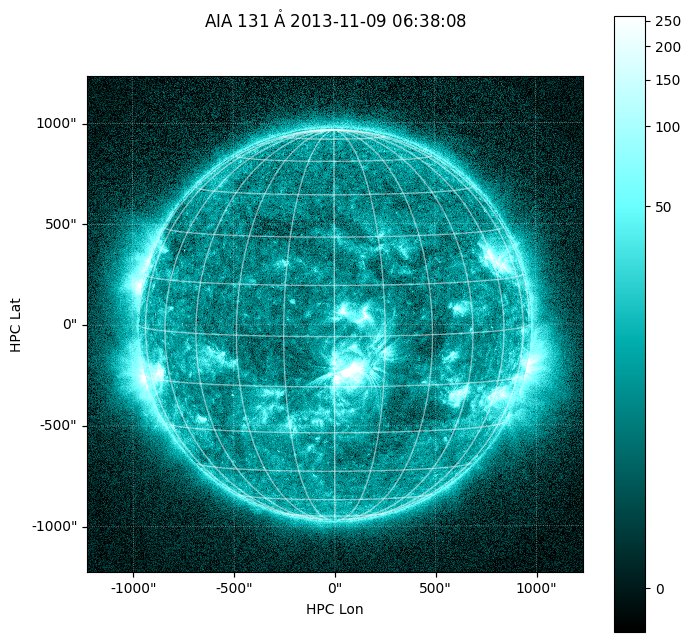

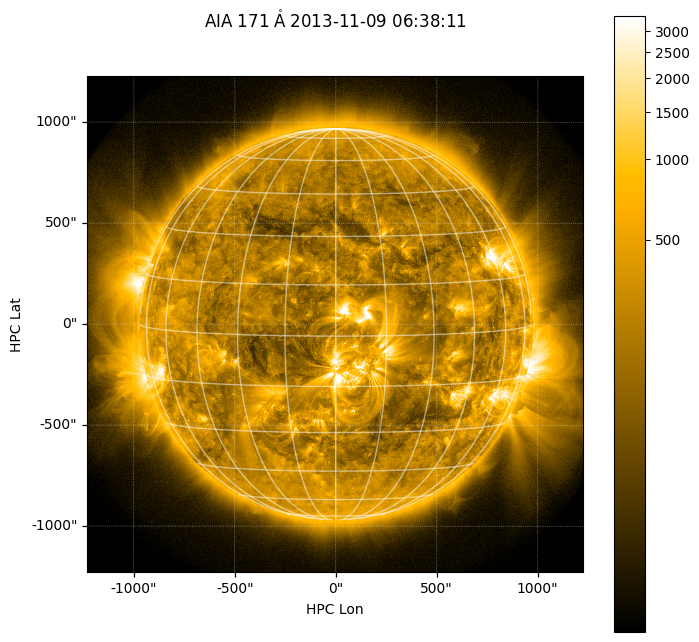

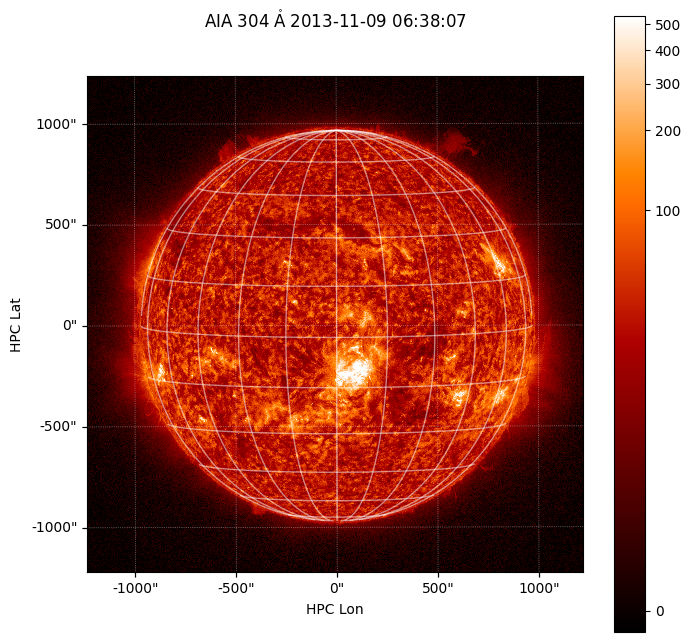

In [17]:
# plt.figure(figsize=(8, 8))
# m_aia[0].plot(vmin=0, vmax=5000)
# m_aia[0].draw_grid(lw=1, alpha=0.5)

for file in m_aia:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection=file)
    im = file.plot(axes=ax, clip_interval=(5,99.9)*u.percent)
    grid = file.draw_grid(axes=ax, lw=1, alpha=0.5)
    # ax.set_title(r'A nicer AIA 304 $\mathrm{\AA}$ Plot')
    ax.coords[0].set_axislabel('HPC Lon')
    ax.coords[1].set_axislabel('HPC Lat')
    fig.colorbar(im)

In [19]:
bottom_left = SkyCoord(lon=-15*u.deg, lat=-30*u.deg, radius=1*sunpy.sun.constants.radius,
                       frame='heliographic_stonyhurst', obstime=m_aia[0].date)
top_right = SkyCoord(lon=30*u.deg, lat=15*u.deg, radius=1*sunpy.sun.constants.radius,
                     frame='heliographic_stonyhurst', obstime=m_aia[0].date)

m_aia_cropped = [image.submap(bottom_left, top_right=top_right) for image in m_aia]

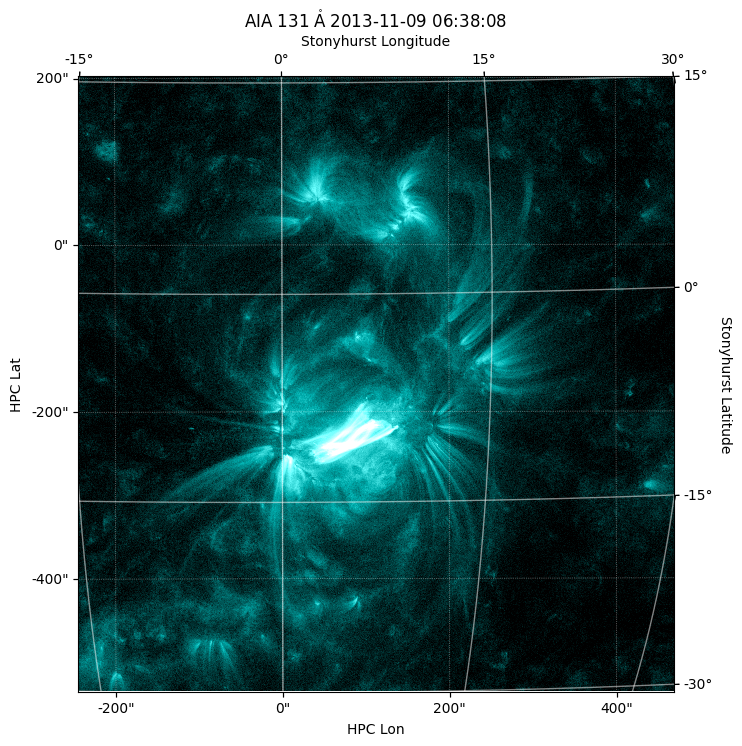

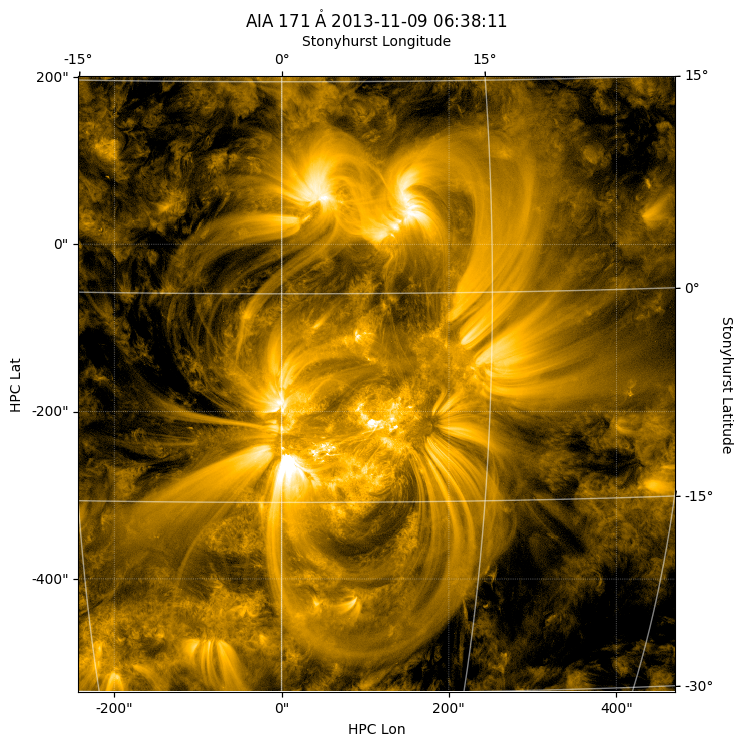

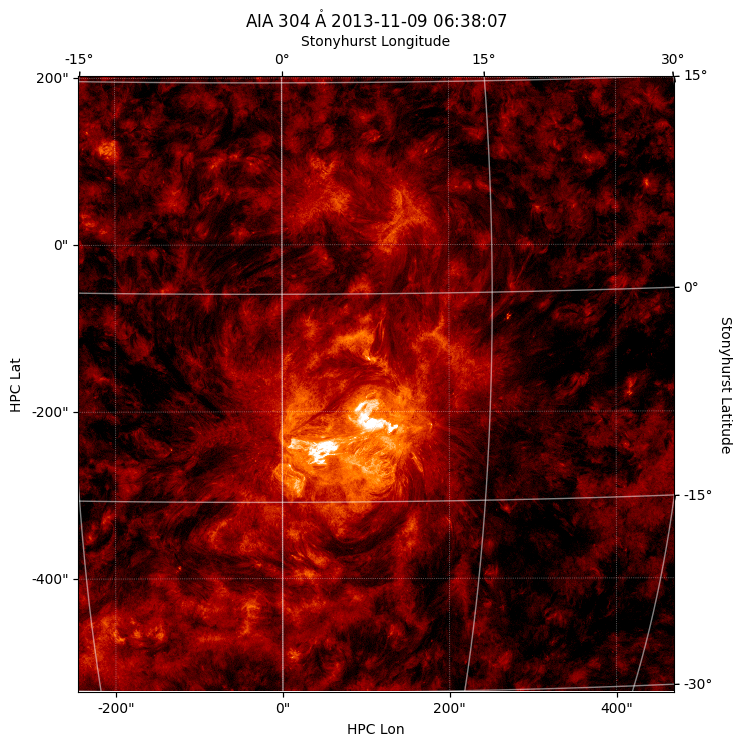

In [22]:
for file in m_aia_cropped:
    fig = plt.figure(figsize=(8,8))
    plt.rcParams['axes.titlepad'] = 35
    ax = fig.add_subplot(projection=file)
    im = file.plot(axes=ax, clip_interval=(5,99.9)*u.percent)
    grid = file.draw_grid(axes=ax, lw=1, alpha=0.5)
    ax.coords[0].set_axislabel('HPC Lon')
    ax.coords[1].set_axislabel('HPC Lat')

    # for fl in flare_coords:
    #     ax.plot_coord(fl, marker='X', color='C0', markersize=15)

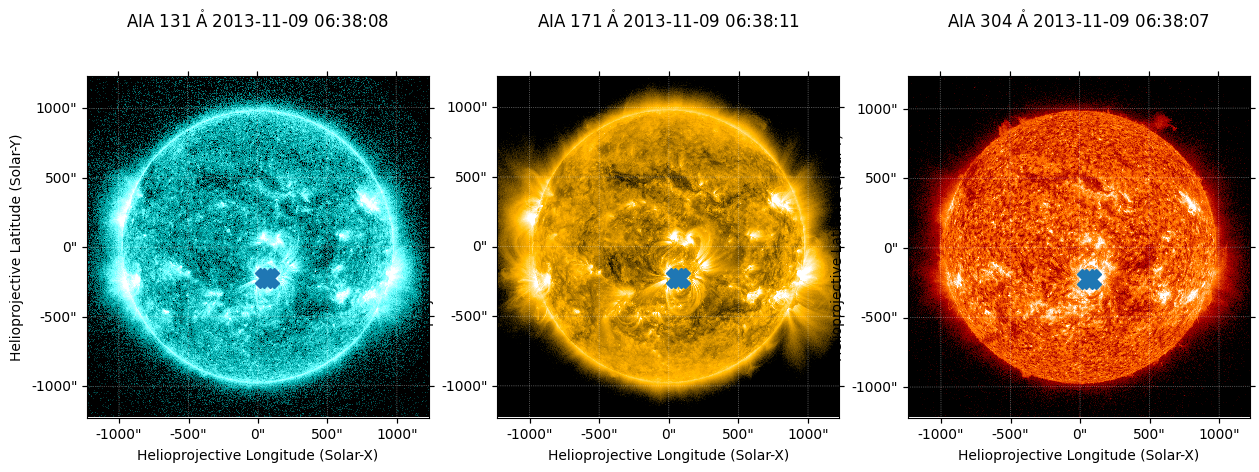

In [24]:
fig = plt.figure(figsize=(15,7.5))
for i, m in enumerate(m_aia):
    ax = fig.add_subplot(1,3,i+1, projection=m)
    m.plot(axes=ax, clip_interval=(25,99.5)*u.percent)
    for fl in flare_coords:
        ax.plot_coord(fl, marker='X', color='C0', markersize=15)